In [1]:
import scanpy as sc
import muon as mu
import anndata as ad
import decoupler as dc
import gseapy
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

## Loading in data, mapping gene symbols, and filtering genes

In [2]:
# Path to the directory containing the count files
directory_path = "/users/PAS1800/ruesch6/Bulk_RNA_Seq_Analysis/250123_MTOR_RNASeq/counts/"  # Replace with the path to your files

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith(".txt"):  # Adjust based on your file format
        file_path = os.path.join(directory_path, file_name)
        
        # Load the file as a DataFrame
        df = pd.read_csv(file_path, sep="\t", comment="#", header=0, index_col="Geneid")
        
        #Split columns to just have sample name and not other info
        df.columns = [col.split("/")[-1].replace("_Aligned.sortedByCoord.out.bam", "") for col in df.columns]
        
        #Remove chromosome, start, end, strand, and length columns to just have counts
        df = df.iloc[:, 5:6]
        
        # Transpose the DataFrame (genes as rows, samples as columns)
        #df = df.T
        
        # Append the DataFrame to the list
        dataframes.append(df)

# Concatenate all DataFrames into one
adata = pd.concat(dataframes, axis=1)  # Combine along rows (samples)

In [3]:
# Retrieve gene symbols
annot = sc.queries.biomart_annotations("hsapiens",
        ["ensembl_gene_id", "external_gene_name"],
        use_cache=False
    ).set_index("ensembl_gene_id")

In [ ]:
#Using mygene to map gene names to ensembl ids
import mygene

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Map Ensembl IDs to gene symbols
ensembl_ids = adata.index.tolist()  # Replace with your Ensembl IDs
annot = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")

# Convert to DataFrame
annot = pd.DataFrame(annot)
annot = annot.set_index("query")

# Drop duplicate Ensembl IDs (keep the first occurrence)
annot = annot[~annot.index.duplicated(keep='first')]

# Map Ensembl IDs to gene symbols in your AnnData object
adata["gene_symbol"] = adata.index.map(annot["symbol"])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [ ]:
#Set gene symbols as index and move ensemble ids their own column
adata = adata.reset_index().rename(columns={'Geneid': 'ensembl_gene_id'}).set_index('gene_symbol')

#Remove ensemble_gene_id from data frame
adata = adata.iloc[:,1:]

# Remove genes with no gene symbol
adata = adata[~adata.index.isna()]

adata = adata.T

In [ ]:
# Transform to AnnData object
adata = adata.astype(np.float32) #needs to be float32 type before converting to anndata object for decoupler to work
adata = ad.AnnData(adata)
adata.var_names_make_unique()
adata

In [ ]:
# Process treatment information
adata.obs['condition'] = ['15-D' if 'FK3' in sample_id else 'DMSO' if 'D' in sample_id else 'RAPA' for sample_id in adata.obs.index]

# Process celltype information
adata.obs['celltype'] = ['S5' if 'Pos' in sample_id else 'S4' for sample_id in adata.obs.index]

#Process donor information
adata.obs['donor'] = ['Donor1' if '1' in sample_id else 'Donor2' if '2' in sample_id else 'Donor3' for sample_id in adata.obs.index]

In [ ]:
# Plot the number of samples by total sum of counts
# You want to set the parameters until the dotted lines are cutting off most of the poorly expressed genes in the bottom
# Everything in the top right quadrant is going to be kept
dc.plot_filter_by_expr(adata, group='condition', min_count=10, min_total_count=15, large_n=3, min_prop=0.67)

In [ ]:
# Once you have your thresholds set, you can proceed with filtering
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group='condition', min_count=10, min_total_count=15, large_n=3, min_prop=0.67)

# Filter by these genes
adata = adata[:, genes].copy()
adata

In [ ]:
adata.obs["c_c_d"] = (
    adata.obs["condition"].astype(str) + "_" +
    adata.obs["celltype"].astype(str) + "_" +
    adata.obs["donor"].astype(str)
)
adata.obs["c_c_d"] = adata.obs["c_c_d"].astype("category")

adata.obs["celltype_condition"] = (
    adata.obs["celltype"].astype(str) + "_" +
    adata.obs["condition"].astype(str)
)
adata.obs["celltype_condition"] = adata.obs["celltype_condition"].astype("category")

In [11]:
# #Save a layer of the counts for deseq analysis because it requries raw counts
# adata.layers['counts'] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e5)
# sc.pp.log1p(adata)
# adata.layers['log_counts'] = adata.X.copy()

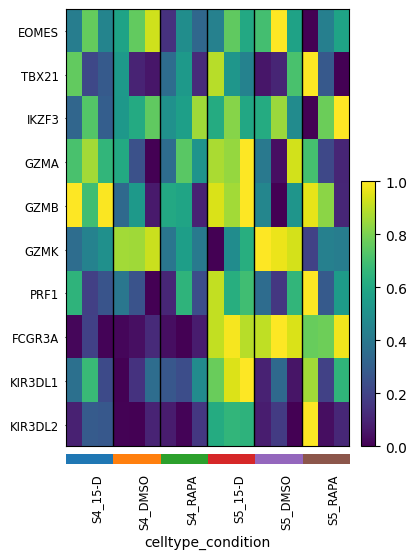

In [13]:
# sc.pl.heatmap(adata, 
#               groupby='celltype_condition', 
#               var_names=['EOMES', 'TBX21', 'IKZF3', 'GZMA', 'GZMB', 'GZMK', 'PRF1', 'FCGR3A', 'KIR3DL1', 'KIR3DL2'], 
#               standard_scale='var', 
#               swap_axes=True, 
#               figsize=(4,6), 
#               dendrogram=False)

In [ ]:
adata.write_h5ad("mTORi_Bulk_ad.h5ad")

## Differential Gene Expression with DESeq2 implementation in python

In [2]:
adata = sc.read_h5ad("mTORi_Bulk_ad.h5ad")

In [3]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [4]:
# Subset by cell type
adata_S4 = adata[adata.obs['celltype'] == 'S4'].copy()
adata_S5 = adata[adata.obs['celltype'] == 'S5'].copy()

inference = DefaultInference(n_cpus=12)

# Create DESeq2 datasets for each cell type
dds_S4 = DeseqDataSet(
    adata=adata_S4,
    design='~condition + donor',  # Compare conditions within this cell type
    refit_cooks=True,
    inference=inference,
)

dds_S5 = DeseqDataSet(
    adata=adata_S5,
    design='~condition + donor',  # Compare conditions within this cell type
    refit_cooks=True,
    inference=inference,
)

In [5]:
# Compute LFCs
dds_S4.deseq2()
dds_S5.deseq2()

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.22 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 1.25 seconds.

Fitting LFCs...
... done in 1.19 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.14 seconds.

Fitting dispersion trend curve...
... done in 0.52 seconds.

Fitting MAP dispersions...
... done in 1.22 seconds.

Fitting LFCs...
... done in 1.11 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [6]:
#CD16- NK cells comparisons
# Compare 15-D vs. DMSO
res_15d_vs_dmso_S4 = DeseqStats(dds_S4, contrast=['condition', '15-D', 'DMSO'])
res_15d_vs_dmso_S4.summary()
# Compare RAPA vs. DMSO
res_rapa_vs_dmso_S4 = DeseqStats(dds_S4, contrast=['condition', 'RAPA', 'DMSO'])
res_rapa_vs_dmso_S4.summary()
# Compare RAPA vs. 15-D
res_rapa_vs_15d_S4 = DeseqStats(dds_S4, contrast=['condition', 'RAPA', '15-D'])
res_rapa_vs_15d_S4.summary()

#CD16+ NK cells comparisons
# Compare 15-D vs. DMSO
res_15d_vs_dmso_S5 = DeseqStats(dds_S5, contrast=['condition', '15-D', 'DMSO'])
res_15d_vs_dmso_S5.summary()
# Compare RAPA vs. DMSO
res_rapa_vs_dmso_S5 = DeseqStats(dds_S5, contrast=['condition', 'RAPA', 'DMSO'])
res_rapa_vs_dmso_S5.summary()
# Compare RAPA vs. 15-D
res_rapa_vs_15d_S5 = DeseqStats(dds_S5, contrast=['condition', 'RAPA', '15-D'])
res_rapa_vs_15d_S5.summary()

Running Wald tests...
... done in 60.29 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition 15-D vs DMSO
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_symbol                                                                     
PEX10             59.159595        0.151971  0.298243  0.509554  6.103637e-01   
PEX14            213.679962        0.119284  0.176942  0.674144  5.002200e-01   
PLCH2           1347.424185       -0.959863  0.152289 -6.302914  2.921016e-10   
SPSB1             29.119285        0.238909  0.425667  0.561257  5.746223e-01   
NMNAT1            50.557411       -0.239377  0.371949 -0.643576  5.198506e-01   
...                     ...             ...       ...       ...           ...   
LOC112268317       9.652656       -0.364173  0.734511 -0.495803  6.200332e-01   
LOC124907090      58.068872       -0.328117  0.302069 -1.086233  2.773761e-01   
LOC124907012       8.528978        0.560574  0.773419  0.724800  4.685748e-01   
LOC124905564      37.674180       -0.567799  0.3

... done in 1.68 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition RAPA vs DMSO
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_symbol                                                                     
PEX10             59.159595        0.186343  0.298736  0.623771  5.327778e-01   
PEX14            213.679962        0.061758  0.177570  0.347798  7.279922e-01   
PLCH2           1347.424185       -0.801021  0.152171 -5.263940  1.410005e-07   
SPSB1             29.119285        0.533534  0.420487  1.268849  2.044950e-01   
NMNAT1            50.557411        0.190422  0.367110  0.518706  6.039655e-01   
...                     ...             ...       ...       ...           ...   
LOC112268317       9.652656       -0.438508  0.740649 -0.592059  5.538113e-01   
LOC124907090      58.068872        0.129500  0.296175  0.437243  6.619353e-01   
LOC124907012       8.528978        0.902794  0.763356  1.182664  2.369423e-01   
LOC124905564      37.674180        0.031096  0.3

... done in 1.89 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition RAPA vs 15-D
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                                 
PEX10             59.159595        0.034372  0.296633  0.115873  0.907753   
PEX14            213.679962       -0.057526  0.176981 -0.325040  0.745151   
PLCH2           1347.424185        0.158841  0.153286  1.036243  0.300089   
SPSB1             29.119285        0.294626  0.415046  0.709863  0.477789   
NMNAT1            50.557411        0.429800  0.370593  1.159762  0.246146   
...                     ...             ...       ...       ...       ...   
LOC112268317       9.652656       -0.074335  0.754069 -0.098578  0.921473   
LOC124907090      58.068872        0.457617  0.301349  1.518564  0.128872   
LOC124907012       8.528978        0.342219  0.739202  0.462958  0.643394   
LOC124905564      37.674180        0.598896  0.387485  1.545598  0.122202   
LOC124904613-1 

... done in 1.67 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition 15-D vs DMSO
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
gene_symbol                                                                     
PEX10             50.355423       -0.138482  0.365115 -0.379284  7.044767e-01   
PEX14            189.163226        0.049307  0.191888  0.256958  7.972111e-01   
PLCH2           1373.551063       -1.015520  0.131184 -7.741193  9.848791e-15   
SPSB1             36.985580        0.685210  0.510293  1.342776  1.793446e-01   
NMNAT1            50.594370       -0.455286  0.349986 -1.300868  1.933036e-01   
...                     ...             ...       ...       ...           ...   
LOC112268317      16.911813       -0.200885  0.734613 -0.273457  7.845018e-01   
LOC124907090      60.214808       -0.720506  0.396072 -1.819127  6.889203e-02   
LOC124907012      12.000970       -0.354850  0.758183 -0.468026  6.397657e-01   
LOC124905564      33.099318       -0.348944  0.4

... done in 1.69 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition RAPA vs DMSO
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                                 
PEX10             50.355423        0.150300  0.369810  0.406426  0.684430   
PEX14            189.163226        0.135177  0.195602  0.691084  0.489513   
PLCH2           1373.551063       -0.533592  0.131540 -4.056486  0.000050   
SPSB1             36.985580        0.025527  0.527703  0.048374  0.961418   
NMNAT1            50.594370       -0.341158  0.357726 -0.953685  0.340243   
...                     ...             ...       ...       ...       ...   
LOC112268317      16.911813        0.654529  0.728995  0.897850  0.369265   
LOC124907090      60.214808        0.371106  0.389708  0.952268  0.340961   
LOC124907012      12.000970        1.020610  0.733788  1.390877  0.164263   
LOC124905564      33.099318        0.582175  0.459339  1.267419  0.205005   
LOC124904613-1 

... done in 1.71 seconds.



In [7]:
#CD16- NK cells comparisons
# Extract results
df_15d_v_dmso_S4 = res_15d_vs_dmso_S4.results_df
df_rapa_v_dmso_S4 = res_rapa_vs_dmso_S4.results_df
df_rapa_v_15d_S4 = res_rapa_vs_15d_S4.results_df

#CD16+ NK cells comparisons
# Extract results
df_15d_v_dmso_S5 = res_15d_vs_dmso_S5.results_df
df_rapa_v_dmso_S5 = res_rapa_vs_dmso_S5.results_df
df_rapa_v_15d_S5 = res_rapa_vs_15d_S5.results_df

In [8]:
# Next I need to convert the results to a wide format and bring them all together for downstream use in decoupler

# CD16- NK cells comparisons
df_15d_v_dmso_S4_stat = df_15d_v_dmso_S4[['stat']].rename(columns={'stat': '15D.vs.DMSO_S4'})
df_rapa_v_dmso_S4_stat = df_rapa_v_dmso_S4[['stat']].rename(columns={'stat': 'RAPA.vs.DMSO_S4'})
df_rapa_v_15d_S4_stat = df_rapa_v_15d_S4[['stat']].rename(columns={'stat': 'RAPA.vs.15D_S4'})

# CD16+ NK cells comparisons
df_15d_v_dmso_S5_stat = df_15d_v_dmso_S5[['stat']].rename(columns={'stat': '15D.vs.DMSO_S5'})
df_rapa_v_dmso_S5_stat = df_rapa_v_dmso_S5[['stat']].rename(columns={'stat': 'RAPA.vs.DMSO_S5'})
df_rapa_v_15d_S5_stat = df_rapa_v_15d_S5[['stat']].rename(columns={'stat': 'RAPA.vs.15D_S5'})

# Combine all T value columns
combined_stat = pd.concat(
    [
        df_15d_v_dmso_S4_stat,
        df_rapa_v_dmso_S4_stat,
        df_rapa_v_15d_S4_stat,
        df_15d_v_dmso_S5_stat,
        df_rapa_v_dmso_S5_stat,
        df_rapa_v_15d_S5_stat,
    ],
    axis=1,  # Concatenate columns
)

# Transpose the combined DataFrame
mat = combined_stat.T

# Rename the index to reflect comparisons
mat.index.name = 'comparison'

mat.to_csv('mTORi_bulk_stats_matrix.csv')

# Display the final matrix
print(mat)

gene_symbol         PEX10     PEX14     PLCH2     SPSB1    NMNAT1      RER1  \
comparison                                                                    
15D.vs.DMSO_S4   0.509554  0.674144 -6.302914  0.561257 -0.643576  1.618393   
RAPA.vs.DMSO_S4  0.623771  0.347798 -5.263940  1.268849  0.518706  1.110979   
RAPA.vs.15D_S4   0.115873 -0.325040  1.036243  0.709863  1.159762 -0.504653   
15D.vs.DMSO_S5  -0.379284  0.256958 -7.741193  1.342776 -1.300868  0.265363   
RAPA.vs.DMSO_S5  0.406426  0.691084 -4.056486  0.048374 -0.953685 -0.356642   
RAPA.vs.15D_S5   0.779268  0.440651  3.632526 -1.269382  0.314947 -0.617929   

gene_symbol         PANK4    VPS13D    GPR157    ZBTB40  ...  LOC102723347-2  \
comparison                                               ...                   
15D.vs.DMSO_S4   0.491149 -3.660748 -1.026232 -2.636348  ...        0.993507   
RAPA.vs.DMSO_S4 -0.549608 -1.442252  1.644647 -0.376832  ...        0.507105   
RAPA.vs.15D_S4  -1.039101  2.216415  2.658734  

## Venn Diagrams of DEGs (Figure S6B)

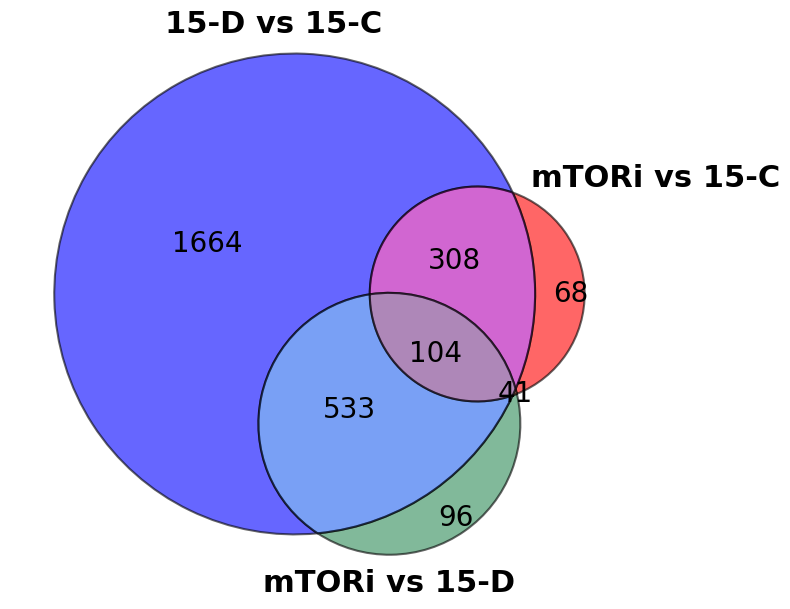

In [31]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# DEG lists
deg_15d_vs_dmso = df_15d_v_dmso_S5[df_15d_v_dmso_S4['padj'] < 0.05].index
deg_rapa_vs_dmso = df_rapa_v_dmso_S5[df_rapa_v_dmso_S4['padj'] < 0.05].index
deg_rapa_vs_15d = df_rapa_v_15d_S5[df_rapa_v_15d_S4['padj'] < 0.05].index

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn_obj = venn3(
    [set(deg_15d_vs_dmso), set(deg_rapa_vs_dmso), set(deg_rapa_vs_15d)],
    set_labels=('15-D vs 15-C', 'mTORi vs 15-C', 'mTORi vs 15-D'),
    set_colors=("blue", "red", "seagreen"),
    alpha=0.6
)

# Add outlines to circles
for patch in venn_obj.patches:
    if patch:
        patch.set_edgecolor('black')   # Outline color
        patch.set_linewidth(1.5)       # Outline thickness

# Style labels
for label in venn_obj.set_labels:
    if label:
        label.set_fontsize(22)
        label.set_weight("bold")
for subset in venn_obj.subset_labels:
    if subset:
        subset.set_fontsize(20)

# Adjust position of "15-D vs 15-C" label (first in the list)
label = venn_obj.set_labels[0]  # index 0 corresponds to the first label
if label:
    label.set_position((0.1, 0.65))  # X and Y coordinates — tweak as needed
    label.set_fontsize(22)

plt.tight_layout()
plt.savefig('figures/S4_Venn_DEGs.png', dpi=300, bbox_inches='tight')
plt.show()


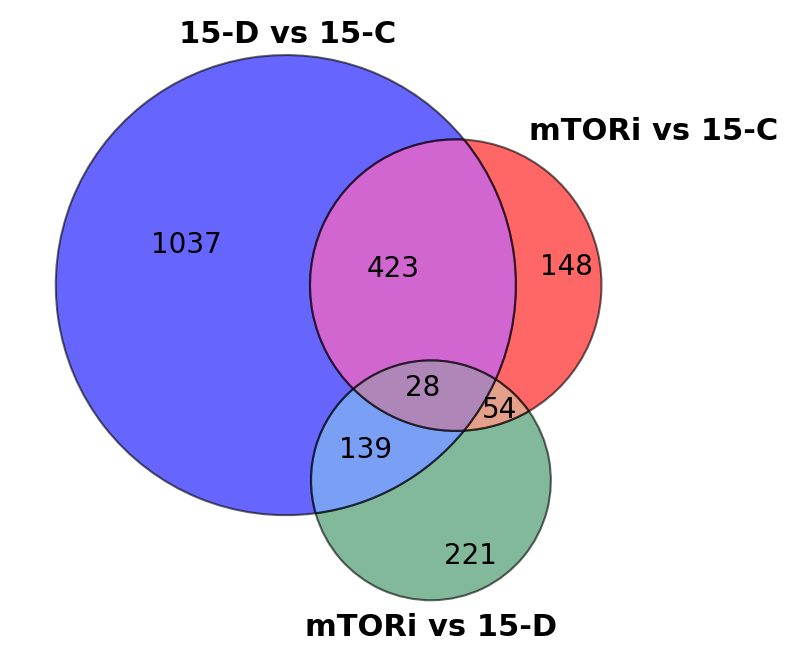

In [32]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# DEG lists
deg_15d_vs_dmso = df_15d_v_dmso_S5[df_15d_v_dmso_S5['padj'] < 0.05].index
deg_rapa_vs_dmso = df_rapa_v_dmso_S5[df_rapa_v_dmso_S5['padj'] < 0.05].index
deg_rapa_vs_15d = df_rapa_v_15d_S5[df_rapa_v_15d_S5['padj'] < 0.05].index

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn_obj = venn3(
    [set(deg_15d_vs_dmso), set(deg_rapa_vs_dmso), set(deg_rapa_vs_15d)],
    set_labels=('15-D vs 15-C', 'mTORi vs 15-C', 'mTORi vs 15-D'),
    set_colors=("blue", "red", "seagreen"),
    alpha=0.6
)

# Add outlines to circles
for patch in venn_obj.patches:
    if patch:
        patch.set_edgecolor('black')   # Outline color
        patch.set_linewidth(1.5)       # Outline thickness

# Style labels
for label in venn_obj.set_labels:
    if label:
        label.set_fontsize(22)
        label.set_weight("bold")
for subset in venn_obj.subset_labels:
    if subset:
        subset.set_fontsize(20)

# Adjust position of "15-D vs 15-C" label (first in the list)
label = venn_obj.set_labels[0]  # index 0 corresponds to the first label
if label:
    label.set_position((0.1, 0.6))  # X and Y coordinates — tweak as needed
    label.set_fontsize(22)

plt.tight_layout()
plt.savefig('figures/S5_Venn_DEGs.png', dpi=300, bbox_inches='tight')
plt.show()


## GSEA comparing to Bulk and Single Cell Gene Sets (Figure 6G)

In [19]:
# Example for RAPA vs DMSO
rapa_S4_ranked = df_rapa_v_dmso_S4.sort_values('log2FoldChange', ascending=False)['log2FoldChange']
rapa_S4_ranked.index = df_rapa_v_dmso_S4.sort_values('log2FoldChange', ascending=False).index

rapa_S5_ranked = df_rapa_v_dmso_S5.sort_values('log2FoldChange', ascending=False)['log2FoldChange']
rapa_S5_ranked.index = df_rapa_v_dmso_S5.sort_values('log2FoldChange', ascending=False).index

# Example for 15D vs DMSO
FK3_S4_ranked = df_15d_v_dmso_S4.sort_values('log2FoldChange', ascending=False)['log2FoldChange']
FK3_S4_ranked.index = df_15d_v_dmso_S4.sort_values('log2FoldChange', ascending=False).index

# Filter to upregulated genes
S4_up = df_15d_v_dmso_S4[df_15d_v_dmso_S4["log2FoldChange"] > 0].copy()
S5_up = df_15d_v_dmso_S5[df_15d_v_dmso_S5["log2FoldChange"] > 0].copy()
# Sort by padj, take top 250
S4_top250 = (S4_up.sort_values("padj", ascending=True).head(250))
S5_top250 = (S5_up.sort_values("padj", ascending=True).head(250))
# Rank those 250 by log2FC
S4_ranked = (S4_top250.sort_values("log2FoldChange", ascending=False))
S5_ranked = (S5_top250.sort_values("log2FoldChange", ascending=False))

# Force uppercase in ranked list and gene sets
rapa_S4_ranked.index = rapa_S4_ranked.index.str.upper()
rapa_S5_ranked.index = rapa_S5_ranked.index.str.upper()
genes_up_15D_S4 = [g.upper() for g in S4_ranked.index.tolist()]
genes_up_15D_S5 = [g.upper() for g in S5_ranked.index.tolist()]

In [20]:
print(len(genes_up_15D_S4))
print(len(genes_up_15D_S5))

250
250


In [21]:
gsea_results_bulk_S4 = gseapy.prerank(
    rnk=rapa_S4_ranked,
    gene_sets={'15D_vs_15C_Bulk': genes_up_15D_S4},
    threads=4,
    permutation_num=1000,
    min_size=5,     # lower than default
    max_size=1000,  # higher than default
    outdir=None,
)
res_bulk_S4 = gsea_results_bulk_S4.res2d.loc[gsea_results_bulk_S4.res2d['Term'] == '15D_vs_15C_Bulk'].iloc[0]

gsea_results_bulk_S5 = gseapy.prerank(
    rnk=rapa_S5_ranked,
    gene_sets={'15D_vs_15C_Bulk': genes_up_15D_S5},
    threads=4,
    permutation_num=1000,
    min_size=5,     # lower than default
    max_size=1000,  # higher than default
    outdir=None,
)

res_bulk_S5 = gsea_results_bulk_S5.res2d.loc[gsea_results_bulk_S5.res2d['Term'] == '15D_vs_15C_Bulk'].iloc[0]

In [12]:
#Load in the D28 NK RNA modality of the mudata object to compare to the DMSO vs mTORi comparison
D28_NK = mu.read_h5ad('/users/PAS1800/ruesch6/Single_Cell_Files/03012023_CITESeq/scanpy_muon/D28_CITESeq_NK.h5mu', mod='rna')

In [13]:
#Directly compare the D28 NK cells from each condition
D28_NK.obs['CD16_condition'] = (D28_NK.obs['CD16_status'].astype(str) + "_" + D28_NK.obs['condition'].astype(str))
sc.tl.rank_genes_groups(D28_NK, 
                        groupby='CD16_condition', 
                        layer='log_counts', 
                        method='wilcoxon', 
                        corr_method='benjamini-hochberg', 
                        groups=['S4_15-D'], 
                        reference='S4_15-C', 
                        use_raw=False,
                        key_added='S4_degs'
                       )

sc.tl.rank_genes_groups(D28_NK, 
                        groupby='CD16_condition', 
                        layer='log_counts', 
                        method='wilcoxon', 
                        corr_method='benjamini-hochberg', 
                        groups=['S5_15-D'], 
                        reference='S5_15-C', 
                        use_raw=False,
                        key_added='S5_degs'
                       )

In [14]:
# Extract from D28_NK the top expressed DEGs
S4_groups = D28_NK.uns['S4_degs']
S4_group = 'S4_15-D'

S4_degs = pd.DataFrame({
    'gene': [g.upper() for g in S4_groups['names'][S4_group]],  # uppercased gene symbols
    'log2fc': S4_groups['logfoldchanges'][S4_group].astype(float),
    'score': S4_groups['scores'][S4_group].astype(float),
    'pval': S4_groups['pvals'][S4_group].astype(float),
    'pval_adj': S4_groups['pvals_adj'][S4_group].astype(float)
})

S5_groups = D28_NK.uns['S5_degs']
S5_group = 'S5_15-D'

S5_degs = pd.DataFrame({
    'gene': [g.upper() for g in S5_groups['names'][S5_group]],  # uppercased gene symbols
    'log2fc': S5_groups['logfoldchanges'][S5_group].astype(float),
    'score': S5_groups['scores'][S5_group].astype(float),
    'pval': S5_groups['pvals'][S5_group].astype(float),
    'pval_adj': S5_groups['pvals_adj'][S5_group].astype(float)
})

In [15]:
# Select top upregulated genes
S4_df_up = S4_degs[S4_degs['log2fc'] > 0].copy()
# Take the top 250 most significant degs (most significant first) 
S4_df_up_sorted = S4_df_up.sort_values("pval_adj", ascending=True).head(250)
# Sort by log2fc descending as the rank for our ranked gene list
S4_df_up_sorted = S4_df_up_sorted.sort_values(by='log2fc', ascending=False)
S4_df_up_sorted = S4_df_up_sorted['gene'].tolist()

# Select top upregulated genes
S5_df_up = S5_degs[S5_degs['log2fc'] > 0].copy()
# Take the top 250 most significant degs (most significant first) 
S5_df_up_sorted = S5_df_up.sort_values("pval_adj", ascending=True).head(250)
# Sort by log2fc descending as the rank for our ranked gene list
S5_df_up_sorted = S5_df_up_sorted.sort_values(by='log2fc', ascending=False)
S5_df_up_sorted = S5_df_up_sorted['gene'].tolist()

In [16]:
print(len(S4_df_up_sorted))
print(len(S5_df_up_sorted))

250
250


In [17]:
gsea_results_sc_S4 = gseapy.prerank(
    rnk=rapa_S4_ranked,
    gene_sets={'15D_vs_15C_SC': S4_df_up_sorted},
    threads=4,
    permutation_num=1000,
    min_size=5,     # lower than default
    max_size=1000,  # higher than default
    outdir=None,
)
res_sc_S4 = gsea_results_sc_S4.res2d.loc[gsea_results_sc_S4.res2d['Term'] == '15D_vs_15C_SC'].iloc[0]

gsea_results_sc_S5 = gseapy.prerank(
    rnk=rapa_S5_ranked,
    gene_sets={'15D_vs_15C_SC': S5_df_up_sorted},
    threads=4,
    permutation_num=1000,
    min_size=5,     # lower than default
    max_size=1000,  # higher than default
    outdir=None,
)

res_sc_S5 = gsea_results_sc_S5.res2d.loc[gsea_results_sc_S5.res2d['Term'] == '15D_vs_15C_SC'].iloc[0]

In [22]:
import matplotlib.pyplot as plt
import gseapy
import os

# --- Your code to generate the four gsea_results objects ---
# (Assuming plot_data is already created as in the previous step)
# Define the data, titles, and term names for your loop
plot_data = [
    {'gsea_res': gsea_results_bulk_S4, 'res': res_bulk_S4, 'title': 'Bulk RNA-Seq (S4)', 'term': '15D_vs_15C_Bulk', 'filename': 'gsea_plot_1.png'},
    {'gsea_res': gsea_results_bulk_S5, 'res': res_bulk_S5, 'title': 'Bulk RNA-Seq (S5)', 'term': '15D_vs_15C_Bulk', 'filename': 'gsea_plot_2.png'},
    {'gsea_res': gsea_results_sc_S4, 'res': res_sc_S4, 'title': 'Single-Cell RNA-Seq (S4)', 'term': '15D_vs_15C_SC', 'filename': 'gsea_plot_3.png'},
    {'gsea_res': gsea_results_sc_S5, 'res': res_sc_S5, 'title': 'Single-Cell RNA-Seq (S5)', 'term': '15D_vs_15C_SC', 'filename': 'gsea_plot_4.png'},
]

import matplotlib.pyplot as plt
import gseapy
import os

# --- Your code to generate the four gsea_results objects ---
# (Assuming plot_data is already created)

# Create a directory to save the figures if it doesn't exist
if not os.path.exists('gsea_figures'):
    os.makedirs('gsea_figures')
    
print("Generating and saving individual GSEA plots with all font adjustments...")

# Loop through your data and plot
for data in plot_data:
    gsea_results = data['gsea_res']
    res = data['res']
    term_name = data['term']
    
    # Capture the list of axes returned by gseaplot
    axes_list = gseapy.plot.gseaplot(
        term=term_name,
        hits=gsea_results.results[term_name]['hits'],
        nes=res['NES'],
        pval=res['NOM p-val'],
        fdr=res['FDR q-val'],
        RES=gsea_results.results[term_name]['RES'],
        rank_metric=gsea_results.ranking,
        pheno_pos="mTORi",
        pheno_neg="DMSO",
        cmap='seismic_r',
        figsize=(6, 10)
    )

    # Access the correct axes for modification
    main_ax = axes_list[0]
    enrichment_ax = axes_list[3]

    # --- Use matplotlib to adjust fonts and axes ---
    
    # 1. Adjust the title
    #main_ax.set_title(data['title'], fontsize=12)
    
    # 2. Adjust the "Enrichment Score" and "Ranked metric" ylabels
    enrichment_ax.set_ylabel(enrichment_ax.get_ylabel(), fontsize=30)
    main_ax.set_ylabel(main_ax.get_ylabel(), fontsize=30)
    
    # 3. Adjust the internal text annotations (NES, p-value, etc.)
    for text in enrichment_ax.texts:
        text.set_fontsize(28)

    # 4. Adjust the font size and color of the DMSO and RAPA labels
    for text in main_ax.texts:
        text.set_fontsize(28)
        # --- Corrected if/else logic for coloring ---
        if text.get_text() == 'mTORi':
            text.set_color('blue')
        elif text.get_text() == 'DMSO':
            text.set_color('red')

    # 5. Adjust the font size of the numbers (tick labels) on the plots
    main_ax.tick_params(axis='y', which='major', labelsize=24)
    enrichment_ax.tick_params(axis='y', which='major', labelsize=24)

    # 6. Customize the X-axis
    # Define the positions and new labels for the ticks
    tick_positions = [0, 2500, 5000, 7500, 10000, 12500, 15000]
    tick_labels = ['0', '2.5', '5', '7.5', '10', '12.5', '15']
    
    # Set the custom ticks and labels
    main_ax.set_xticks(tick_positions)
    main_ax.set_xticklabels(tick_labels, fontsize=24)
    
    # Set the new x-axis label
    main_ax.set_xlabel('Gene Rank (x1000)', fontsize=30)

    # 7. Save the MODIFIED figure
    fig = main_ax.get_figure()
    fig.savefig(os.path.join('gsea_figures', data['filename']), bbox_inches='tight')
    
    # Close the figure to free up memory
    plt.close(fig)

print("Individual plots saved successfully.")

# You can now run your code to assemble the final 4-panel figure.

Generating and saving individual GSEA plots with all font adjustments...
Individual plots saved successfully.


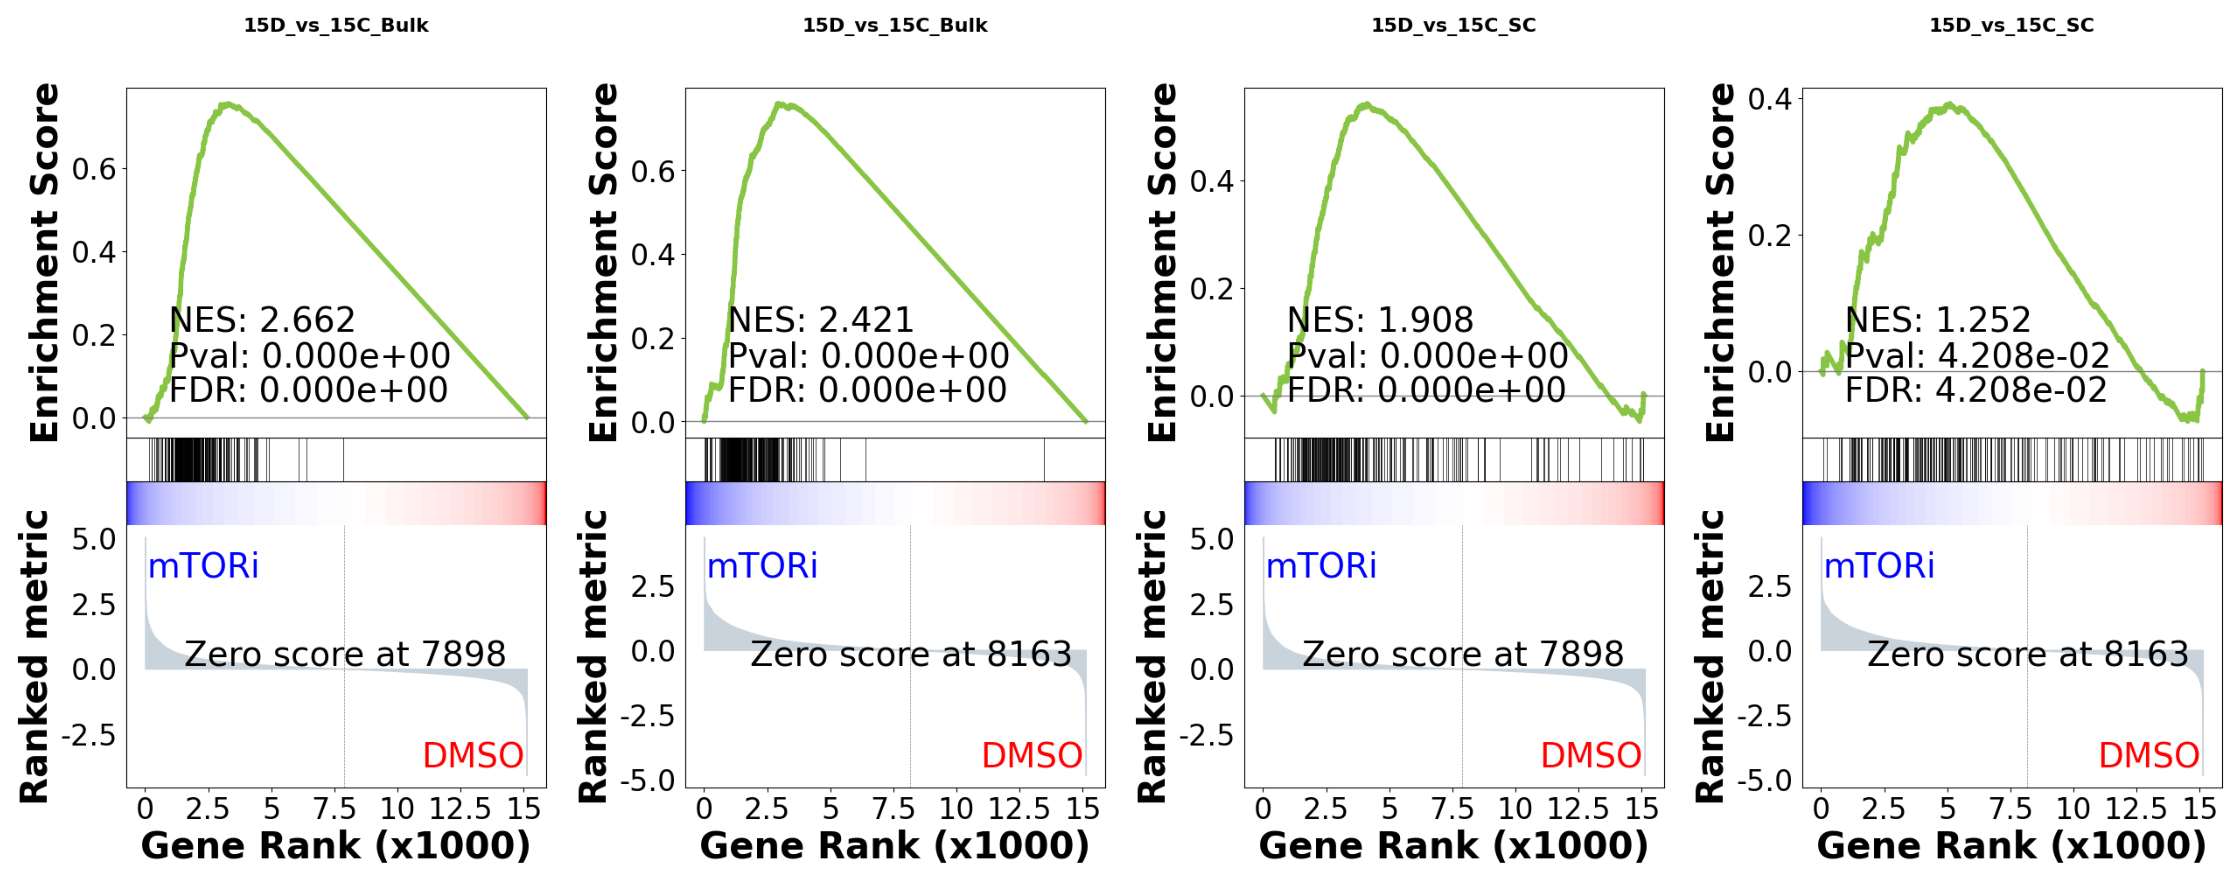

In [24]:
# --- Assemble the final 4-panel figure from saved images ---

# Create the figure and subplot grid with your desired ratio
fig, axes = plt.subplots(1, 4, figsize=(22.5, 10))

# Loop through the data again to load and display each saved image
for i, data in enumerate(plot_data):
    # Load the saved image
    img = plt.imread(os.path.join('gsea_figures', data['filename']))
    
    # Display the image in the correct subplot
    axes[i].imshow(img)
    
    # Turn off the axis ticks and labels for a cleaner look
    axes[i].axis('off')

# Add a main title for the entire figure
#fig.suptitle("Rapamycin Treatment Mimics the 15D Transcriptional Signature", fontsize=20, y=0.73) # Adjust y for positioning

# Clean up the layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('gsea_figures/combined.png')
plt.show()

## TF activity inference through CollecTRI (Figure S6C)  
This is activity inference prior to adjusting for proliferation

Carrying on, now we use the mat object with our comparisons to do further analyses of our datasets. Lets start by inferring transcription factor pathways using CollecTRI acquired from Decoupler

In [19]:
mat = pd.read_csv('mTORi_bulk_stats_matrix.csv', index_col=0)

In [12]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [21]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 6 samples and 15124 targets for 622 sources.


,ABL1,AHR,AIP,AIRE,AP1,APEX1,AR,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
15D.vs.DMSO_S4,0.916283,0.762874,1.001860,0.354775,1.346933,1.819381,1.912058,5.444427,1.603145,-0.120004,...,-1.083627,1.505948,-0.646743,0.874555,1.098993,2.394218,1.041144,1.093484,-0.079825,-3.289335
RAPA.vs.DMSO_S4,0.765886,0.856614,0.508511,1.396508,3.123277,2.107968,1.235524,3.307907,0.812575,1.035751,...,-0.123278,1.418090,-0.420334,0.655656,-0.377730,1.745515,0.477473,0.164507,0.706750,-2.745072
RAPA.vs.15D_S4,-0.581753,-0.283422,-0.943552,0.778757,1.023389,-0.611808,-1.560887,-4.639843,-1.512501,1.138806,...,1.435327,-0.807398,0.523413,-0.634934,-1.909149,-1.777770,-1.030084,-1.398474,0.742391,2.096714
15D.vs.DMSO_S5,0.809274,0.437978,0.658900,-0.671477,0.648528,1.718799,2.560302,4.533977,1.492326,0.012959,...,-1.532754,1.274601,-0.090895,1.568738,2.049512,2.862724,1.012757,1.573230,0.508733,-1.833417
RAPA.vs.DMSO_S5,-0.400103,0.655306,-0.659142,0.967591,0.576911,1.715441,0.705011,2.374418,0.591554,0.241631,...,-0.361320,0.811982,1.005248,2.019409,1.137649,2.327429,0.386898,0.177034,0.679440,-2.139217
RAPA.vs.15D_S5,-1.416273,0.125659,-1.496974,1.821951,-0.196186,-0.425379,-2.525882,-3.259421,-1.260150,0.235431,...,1.582178,-0.760843,1.125223,0.098813,-1.418855,-1.231645,-0.887979,-1.791265,0.052292,0.138109


Generate a heatmap of differential TF Regulon Activity (Figure S6C)

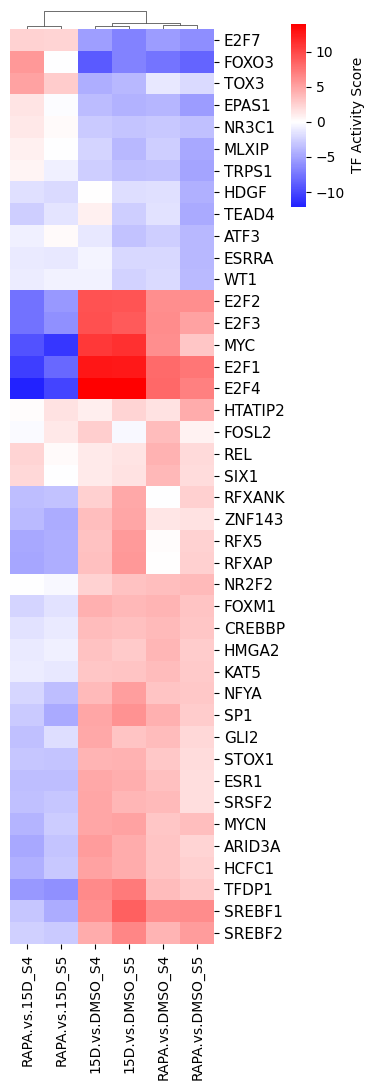

In [26]:
# --- Your code to select tfs_to_plot and create heatmap_data is correct ---
top_15d_S4 = tf_acts.loc['15D.vs.DMSO_S4'].abs().sort_values(ascending=False).head(20).index
top_rapa_S4 = tf_acts.loc['RAPA.vs.DMSO_S4'].abs().sort_values(ascending=False).head(20).index
top_15d_S5 = tf_acts.loc['15D.vs.DMSO_S5'].abs().sort_values(ascending=False).head(20).index
top_rapa_S5 = tf_acts.loc['RAPA.vs.DMSO_S5'].abs().sort_values(ascending=False).head(20).index
tfs_to_plot = top_15d_S4.union(top_rapa_S4).union(top_15d_S5).union(top_rapa_S5)
heatmap_data = tf_acts.loc[
    ['15D.vs.DMSO_S4', 'RAPA.vs.DMSO_S4', 'RAPA.vs.15D_S4',
     '15D.vs.DMSO_S5', 'RAPA.vs.DMSO_S5', 'RAPA.vs.15D_S5'], 
    tfs_to_plot
]
# --- End of previous code ---


# Create the clustermap
g = sns.clustermap(
    heatmap_data.T,
    cmap='bwr',
    center=0,
    figsize=(3, 11),
    cbar_kws={'label': 'TF Activity Score'},
    dendrogram_ratio=(0, 0.02) 
)

# Adjust TF name font size
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=11)

# Rotate the x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)


# --- NEW: Move the color bar to the right ---
# Get the current position of the heatmap [left, bottom, width, height]
heatmap_pos = g.ax_heatmap.get_position()
# Set the new position of the color bar to be to the right of the heatmap
g.ax_cbar.set_position([heatmap_pos.x1 * 1.35, heatmap_pos.y1 / 1.2, 0.05, heatmap_pos.height * 0.2])

plt.savefig('figures/tf_activity_clustered_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Differential Gene Expression with DESeq2 with Proliferation as a Covariate (Figure 6H)
Using the signature from the pNK clusters in our CITE-seq dataset to created the signature

In [3]:
D28_NK = mu.read_h5ad('/users/PAS1800/ruesch6/Single_Cell_Files/03012023_CITESeq/scanpy_muon/D28_CITESeq_NK.h5mu', mod='rna')

In [4]:
sc.tl.rank_genes_groups(D28_NK, groupby='celltype', groups=['pNK'], reference='NK', method='wilcoxon', corr_method='benjamini-hochberg', layer='log_counts', use_raw=False)

In [5]:
result_df = pd.DataFrame(D28_NK.uns['rank_genes_groups']['names'])
proliferation_signature = result_df['pNK'].head(50).tolist()
# Print a few genes to check
print("Custom Proliferation Signature Genes:")
print(proliferation_signature[:50])

Custom Proliferation Signature Genes:
['TUBA1B', 'TUBB', 'STMN1', 'PTMA', 'HMGB2', 'MKI67', 'H2AFZ', 'HMGB1', 'TMPO', 'HMGN2', 'RRM2', 'SMC4', 'DEK', 'PCLAF', 'TOP2A', 'TUBB4B', 'TYMS', 'MCM7', 'KNL1', 'TPX2', 'CLSPN', 'NUSAP1', 'CENPF', 'ANP32B', 'CENPM', 'ASF1B', 'DUT', 'RAN', 'FANCI', 'FEN1', 'NUCKS1', 'KIFC1', 'ZWINT', 'ASPM', 'CKS1B', 'ATAD2', 'SMC2', 'UBE2C', 'H2AFV', 'GTSE1', 'CDCA8', 'DDX39A', 'CHCHD2', 'HNRNPA2B1', 'NCAPH', 'KIF11', 'PRC1', 'PCNA', 'CENPU', 'AC011603.2']


In [6]:
adata = sc.read_h5ad("mTORi_Bulk_ad.h5ad")

Run a PCA of the top 50 proliferation genes from the cultures and then use the scores from PC1 as the covariate in the analysis

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [9]:
# Create a temporary, normalized AnnData object just for scoring
adata_for_scoring = adata.copy()
sc.pp.normalize_total(adata_for_scoring, target_sum=1e4)
sc.pp.log1p(adata_for_scoring)

# 1. Get your top genes from the SC results
raw_signature = result_df['pNK'].head(100).tolist()

# 2. Keep ONLY genes that actually exist in your Bulk RNA-seq var_names
# This prevents the KeyError by filtering out the missing ones
available_genes = [g for g in raw_signature if g in adata_for_scoring.var_names]

# 3. Take the first 50 of those available genes
proliferation_signature_50 = available_genes[:50]

print(f"Matched {len(proliferation_signature_50)} genes for scoring.")

# Now the subsetting will work perfectly
subset_data = adata_for_scoring[:, proliferation_signature_50].X

# If it's a sparse matrix, convert to dense
if hasattr(subset_data, "toarray"):
    subset_data = subset_data.toarray()

# 4. Z-score the genes first (Crucial for PCA)
# This ensures a high-expression gene doesn't dominate the PC just because of its magnitude
scaled_subset = StandardScaler().fit_transform(subset_data)

# 4. Run PCA
pca = PCA(n_components=1)
pc1_scores = pca.fit_transform(scaled_subset)

# 5. Add back to your main adata.obs
adata.obs['proliferation_pc1'] = pc1_scores

# 6. Check the "Explained Variance"
print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance in the signature.")

# Display the scores to verify
print("Proliferation scores added to adata.obs:")
print(adata.obs[['condition', 'celltype', 'proliferation_pc1']])

Matched 50 genes for scoring.
PC1 explains 93.09% of the variance in the signature.
Proliferation scores added to adata.obs:
          condition celltype  proliferation_pc1
D_Neg_2        DMSO       S4          -4.912860
FK3_Neg_2      15-D       S4          10.264523
R_Pos_1        RAPA       S5           6.967016
FK3_Neg_3      15-D       S4           9.227736
D_Neg_1        DMSO       S4          -0.811830
FK3_Pos_3      15-D       S5           1.699651
R_Pos_2        RAPA       S5          -5.766333
R_Neg_1        RAPA       S4           1.987573
D_Pos_3        DMSO       S5         -10.008242
FK3_Neg_1      15-D       S4          10.245399
FK3_Pos_1      15-D       S5           4.544312
R_Neg_2        RAPA       S4           5.271909
R_Neg_3        RAPA       S4          -2.321180
D_Pos_1        DMSO       S5          -7.871873
D_Neg_3        DMSO       S4          -4.740175
FK3_Pos_2      15-D       S5           4.609856
R_Pos_3        RAPA       S5          -8.876670
D_Pos_2    

In [10]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [11]:
# Subset by cell type
adata_S4 = adata[adata.obs['celltype'] == 'S4'].copy()
adata_S5 = adata[adata.obs['celltype'] == 'S5'].copy()

inference = DefaultInference(n_cpus=12)

# Create DESeq2 datasets for each cell type
dds_S4 = DeseqDataSet(
    adata=adata_S4,
    design='~proliferation_pc1 + condition + donor',  # Compare conditions within this cell type
    refit_cooks=True,
    inference=inference,
)

dds_S5 = DeseqDataSet(
    adata=adata_S5,
    design='~proliferation_pc1 + condition + donor',  # Compare conditions within this cell type
    refit_cooks=True,
    inference=inference,
)

In [12]:
# Compute LFCs
dds_S4.deseq2()
dds_S5.deseq2()

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.13 seconds.

Fitting dispersion trend curve...
... done in 0.30 seconds.

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:548: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.19 seconds.

Fitting LFCs...
... done in 1.25 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.01 seconds.

Fitting dispersion trend curve...
... done in 0.31 seconds.

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/pydeseq2/dds.py:548: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.17 seconds.

Fitting LFCs...
... done in 1.15 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [13]:
#CD16- NK cells comparisons
# Compare 15-D vs. DMSO
res_15d_vs_dmso_S4 = DeseqStats(dds_S4, contrast=['condition', '15-D', 'DMSO'])
res_15d_vs_dmso_S4.summary()
# Compare RAPA vs. DMSO
res_rapa_vs_dmso_S4 = DeseqStats(dds_S4, contrast=['condition', 'RAPA', 'DMSO'])
res_rapa_vs_dmso_S4.summary()
# Compare RAPA vs. 15-D
res_rapa_vs_15d_S4 = DeseqStats(dds_S4, contrast=['condition', 'RAPA', '15-D'])
res_rapa_vs_15d_S4.summary()

#CD16+ NK cells comparisons
# Compare 15-D vs. DMSO
res_15d_vs_dmso_S5 = DeseqStats(dds_S5, contrast=['condition', '15-D', 'DMSO'])
res_15d_vs_dmso_S5.summary()
# Compare RAPA vs. DMSO
res_rapa_vs_dmso_S5 = DeseqStats(dds_S5, contrast=['condition', 'RAPA', 'DMSO'])
res_rapa_vs_dmso_S5.summary()
# Compare RAPA vs. 15-D
res_rapa_vs_15d_S5 = DeseqStats(dds_S5, contrast=['condition', 'RAPA', '15-D'])
res_rapa_vs_15d_S5.summary()

Running Wald tests...
... done in 55.29 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition 15-D vs DMSO
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                                 
PEX10             59.159595        0.049267  1.123227  0.043862  0.965014   
PEX14            213.679962       -0.331635  0.631341 -0.525286  0.599384   
PLCH2           1347.424185        0.351803  0.392382  0.896584  0.369941   
SPSB1             29.119285       -0.213758  1.567233 -0.136392  0.891511   
NMNAT1            50.557411        0.001727  1.392659  0.001240  0.999010   
...                     ...             ...       ...       ...       ...   
LOC112268317       9.652656        0.324813  3.113048  0.104339  0.916900   
LOC124907090      58.068872       -0.065576  1.126444 -0.058215  0.953577   
LOC124907012       8.528978       -0.184562  2.897426 -0.063699  0.949210   
LOC124905564      37.674180        1.019288  1.426130  0.714723  0.474780   
LOC124904613-1 

... done in 1.65 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition RAPA vs DMSO
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                                 
PEX10             59.159595        0.147929  0.516599  0.286353  0.774608   
PEX14            213.679962       -0.108047  0.290864 -0.371469  0.710288   
PLCH2           1347.424185       -0.318845  0.179286 -1.778416  0.075336   
SPSB1             29.119285        0.349409  0.754252  0.463252  0.643184   
NMNAT1            50.557411        0.287843  0.635131  0.453203  0.650403   
...                     ...             ...       ...       ...       ...   
LOC112268317       9.652656       -0.219248  1.222068 -0.179407  0.857618   
LOC124907090      58.068872        0.229557  0.511150  0.449098  0.653361   
LOC124907012       8.528978        0.632900  1.293868  0.489153  0.624733   
LOC124905564      37.674180        0.597792  0.620981  0.962658  0.335719   
LOC124904613-1 

... done in 1.92 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition RAPA vs 15-D
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                                 
PEX10             59.159595        0.098662  0.738432  0.133611  0.893710   
PEX14            213.679962        0.223588  0.414816  0.539006  0.589883   
PLCH2           1347.424185       -0.670648  0.259368 -2.585702  0.009718   
SPSB1             29.119285        0.563167  0.995493  0.565716  0.571587   
NMNAT1            50.557411        0.286116  0.920285  0.310899  0.755877   
...                     ...             ...       ...       ...       ...   
LOC112268317       9.652656       -0.544061  2.227712 -0.244224  0.807057   
LOC124907090      58.068872        0.295133  0.746847  0.395172  0.692716   
LOC124907012       8.528978        0.817462  1.936323  0.422172  0.672899   
LOC124905564      37.674180       -0.421496  0.968768 -0.435085  0.663501   
LOC124904613-1 

... done in 1.66 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition 15-D vs DMSO
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                                 
PEX10             50.355423       -0.712917  0.755343 -0.943833  0.345255   
PEX14            189.163226        0.078640  0.404843  0.194247  0.845982   
PLCH2           1373.551063       -0.654126  0.243988 -2.680976  0.007341   
SPSB1             36.985580        0.921354  1.108363  0.831275  0.405818   
NMNAT1            50.594370       -0.725975  0.748499 -0.969907  0.332093   
...                     ...             ...       ...       ...       ...   
LOC112268317      16.911813        2.591199  1.481803  1.748680  0.080346   
LOC124907090      60.214808       -0.156007  0.819520 -0.190364  0.849024   
LOC124907012      12.000970        0.369362  1.602102  0.230549  0.817665   
LOC124905564      33.099318        0.119409  0.976459  0.122288  0.902671   
LOC124904613-1 

... done in 1.67 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition RAPA vs DMSO
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_symbol                                                                 
PEX10             50.355423       -0.160369  0.507340 -0.316099  0.751928   
PEX14            189.163226        0.150322  0.270041  0.556665  0.577756   
PLCH2           1373.551063       -0.353433  0.159696 -2.213166  0.026886   
SPSB1             36.985580        0.150097  0.742084  0.202264  0.839711   
NMNAT1            50.594370       -0.483573  0.503072 -0.961241  0.336431   
...                     ...             ...       ...       ...       ...   
LOC112268317      16.911813        1.846238  0.899585  2.052321  0.040139   
LOC124907090      60.214808        0.648101  0.534006  1.213659  0.224878   
LOC124907012      12.000970        1.348378  0.989669  1.362453  0.173055   
LOC124905564      33.099318        0.806453  0.624137  1.292109  0.196319   
LOC124904613-1 

... done in 1.68 seconds.



In [14]:
#CD16- NK cells comparisons
# Extract results
df_15d_v_dmso_S4 = res_15d_vs_dmso_S4.results_df
df_rapa_v_dmso_S4 = res_rapa_vs_dmso_S4.results_df
df_rapa_v_15d_S4 = res_rapa_vs_15d_S4.results_df

#CD16+ NK cells comparisons
# Extract results
df_15d_v_dmso_S5 = res_15d_vs_dmso_S5.results_df
df_rapa_v_dmso_S5 = res_rapa_vs_dmso_S5.results_df
df_rapa_v_15d_S5 = res_rapa_vs_15d_S5.results_df

In [16]:
# Next I need to convert the results to a wide format and bring them all together for downstream use in decoupler

# CD16- NK cells comparisons
df_15d_v_dmso_S4_stat = df_15d_v_dmso_S4[['stat']].rename(columns={'stat': '15D.vs.DMSO_S4'})
df_rapa_v_dmso_S4_stat = df_rapa_v_dmso_S4[['stat']].rename(columns={'stat': 'RAPA.vs.DMSO_S4'})
df_rapa_v_15d_S4_stat = df_rapa_v_15d_S4[['stat']].rename(columns={'stat': 'RAPA.vs.15D_S4'})

# CD16+ NK cells comparisons
df_15d_v_dmso_S5_stat = df_15d_v_dmso_S5[['stat']].rename(columns={'stat': '15D.vs.DMSO_S5'})
df_rapa_v_dmso_S5_stat = df_rapa_v_dmso_S5[['stat']].rename(columns={'stat': 'RAPA.vs.DMSO_S5'})
df_rapa_v_15d_S5_stat = df_rapa_v_15d_S5[['stat']].rename(columns={'stat': 'RAPA.vs.15D_S5'})

# Combine all T value columns
combined_stat = pd.concat(
    [
        df_15d_v_dmso_S4_stat,
        df_rapa_v_dmso_S4_stat,
        df_rapa_v_15d_S4_stat,
        df_15d_v_dmso_S5_stat,
        df_rapa_v_dmso_S5_stat,
        df_rapa_v_15d_S5_stat,
    ],
    axis=1,  # Concatenate columns
)

# Transpose the combined DataFrame
mat = combined_stat.T

# Rename the index to reflect comparisons
mat.index.name = 'comparison'

mat.to_csv('mTORi_bulk_stats_prolif_corrected_matrix.csv')

# Display the final matrix
print(mat)

gene_symbol         PEX10     PEX14     PLCH2     SPSB1    NMNAT1      RER1  \
comparison                                                                    
15D.vs.DMSO_S4   0.043862 -0.525286  0.896584 -0.136392  0.001240  0.464229   
RAPA.vs.DMSO_S4  0.286353 -0.371469 -1.778416  0.463252  0.453203  0.692820   
RAPA.vs.15D_S4   0.133611  0.539006 -2.585702  0.565716  0.310899 -0.220628   
15D.vs.DMSO_S5  -0.943833  0.194247 -2.680976  0.831275 -0.969907 -0.114286   
RAPA.vs.DMSO_S5 -0.316099  0.556665 -2.213166  0.202264 -0.961241 -0.449114   
RAPA.vs.15D_S5   1.142712  0.275543  1.902206 -1.095985  0.504672 -0.289026   

gene_symbol         PANK4    VPS13D    GPR157    ZBTB40  ...  LOC102723347-2  \
comparison                                               ...                   
15D.vs.DMSO_S4   0.275176 -0.076202 -0.734411  0.511205  ...        0.637727   
RAPA.vs.DMSO_S4 -0.215954 -0.092622  0.579897  0.850756  ...        0.606971   
RAPA.vs.15D_S4  -0.567949  0.051028  1.521598 -

In [17]:
mat = pd.read_csv('mTORi_bulk_stats_prolif_corrected_matrix.csv', index_col=0)

In [18]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [19]:
# Infer TF activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 6 samples and 15124 targets for 622 sources.


,ABL1,AHR,AIP,AIRE,AP1,APEX1,AR,ARID3A,ARID3B,ARID4A,...,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91
15D.vs.DMSO_S4,2.382468,1.809425,-0.733537,1.962445,2.704101,0.652497,0.999016,1.730019,0.336386,-0.095844,...,2.293474,1.003165,-1.095203,2.001052,-1.015958,1.030513,0.276397,-1.639020,-0.513452,0.695560
RAPA.vs.DMSO_S4,2.112327,1.599105,-0.603446,2.759099,3.823895,1.323975,0.921092,1.560599,0.193412,0.857135,...,1.222428,1.363004,-0.938838,1.268364,-1.455055,1.088314,0.215563,-1.702567,0.494126,-0.338042
RAPA.vs.15D_S4,-1.922098,-1.438996,0.624601,-0.904238,-1.163078,0.021855,-0.775112,-1.374704,-0.342195,0.792665,...,-2.352578,-0.455732,0.896026,-1.973677,0.403810,-0.717155,-0.254778,1.146260,1.111120,-1.291718
15D.vs.DMSO_S5,1.464744,0.593294,-1.437360,0.659535,2.576358,1.069255,-0.702156,0.985331,-0.790283,-0.521549,...,0.090042,-0.026834,1.372998,0.571367,1.785926,1.758430,1.839787,0.052137,0.373831,-0.537602
RAPA.vs.DMSO_S5,-0.208544,0.680960,-1.723648,1.608638,1.284087,1.120161,-1.122568,-0.081753,-0.743207,-0.089871,...,0.374165,0.006071,1.722006,1.168830,0.841074,1.146746,0.776321,-0.743189,0.618457,-1.216537
RAPA.vs.15D_S5,-2.494922,0.077069,-0.193693,1.249399,-2.158680,-0.026510,-0.504473,-1.620846,0.202388,0.728754,...,0.459212,0.103687,0.248828,0.882411,-1.564644,-1.045944,-1.848851,-1.123832,0.279678,-0.838296


Generate a heatmap of differential TF Regulon Activity (Figure S6C)

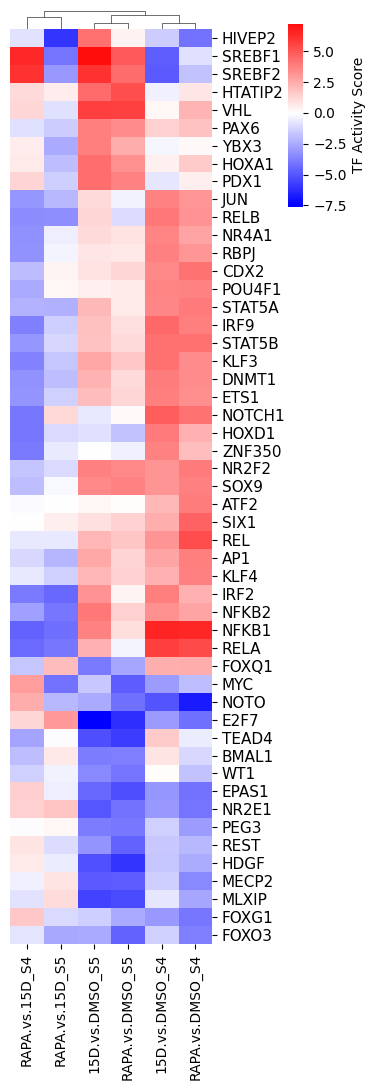

In [20]:
# --- Your code to select tfs_to_plot and create heatmap_data is correct ---
top_15d_S4 = tf_acts.loc['15D.vs.DMSO_S4'].abs().sort_values(ascending=False).head(20).index
top_rapa_S4 = tf_acts.loc['RAPA.vs.DMSO_S4'].abs().sort_values(ascending=False).head(20).index
top_15d_S5 = tf_acts.loc['15D.vs.DMSO_S5'].abs().sort_values(ascending=False).head(20).index
top_rapa_S5 = tf_acts.loc['RAPA.vs.DMSO_S5'].abs().sort_values(ascending=False).head(20).index
tfs_to_plot = top_15d_S4.union(top_rapa_S4).union(top_15d_S5).union(top_rapa_S5)
heatmap_data = tf_acts.loc[
    ['15D.vs.DMSO_S4', 'RAPA.vs.DMSO_S4', 'RAPA.vs.15D_S4',
     '15D.vs.DMSO_S5', 'RAPA.vs.DMSO_S5', 'RAPA.vs.15D_S5'], 
    tfs_to_plot
]
# --- End of previous code ---


# Create the clustermap
g = sns.clustermap(
    heatmap_data.T,
    cmap='bwr',
    center=0,
    figsize=(3, 11),
    cbar_kws={'label': 'TF Activity Score'},
    dendrogram_ratio=(0, 0.02) 
)

# Adjust TF name font size
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=11)

# Rotate the x-axis labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)


# --- NEW: Move the color bar to the right ---
# Get the current position of the heatmap [left, bottom, width, height]
heatmap_pos = g.ax_heatmap.get_position()
# Set the new position of the color bar to be to the right of the heatmap
g.ax_cbar.set_position([heatmap_pos.x1 * 1.35, heatmap_pos.y1 / 1.2, 0.05, heatmap_pos.height * 0.2])

plt.savefig('figures/tf_activity_prolif_corrected_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Session Info

In [9]:
import session_info
session_info.show(excludes=['distributed'])

/users/PAS1800/ruesch6/.conda/envs/single_cell/lib/python3.12/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
